# Lab 2: One-Dimensional Linear Regression (Batch Gradient Descent)


## Abstract
In this lab, we will investigate **multivariate linear regression** using two approaches:
- **Gradient Descent** (iterative optimization), and
- the **Normal Equation** (closed-form solution).

We will later examine how the **cost function** $J(\theta)$ reflects the **convergence** behavior under different **learning rates** $\alpha$.


In [7]:
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import display
import matplotlib.pyplot as plt

### 1. Data Loading

**Dataset.** Housing prices in Portland, Oregon.  
- **Features (X):** living area (sqft), number of bedrooms.  
- **Target (y):** house price.  
- **Size:** $m = 47$ training examples.

**In this section we do the following:**
- Load `ex2x.dat` (features) and `ex2y.dat` (targets).
- Check shapes and preview the first few rows to confirm the data is correct.
- No preprocessing or training here; this step is only for loading and sanity checks.


In [8]:
X_path=Path("ex2Data/ex2x.dat")
y_path=Path("ex2Data/ex2y.dat")
if not X_path.exists() or not y_path.exists():
    raise FileNotFoundError(
        "Data files not found. Make sure 'ex2x.dat' and 'ex2y.dat' are in the working directory.\n"
        f"Current directory: {Path('.').resolve()}\n"
        f"Here are the files I see: {[p.name for p in Path('.').iterdir()]}"
    )
X_raw=pd.read_csv(X_path,header=None,sep=r"\s+").astype(float)
y_raw=pd.read_csv(y_path,header=None,sep=r"\s+").astype(float)
if(X_raw.shape[1]==2):
    X_raw.columns=["area","bedrooms"]
else:
    X_raw.columns=[f"feature_{i}" for i in range(X_raw.shape[1])]
y_raw.columns=["price"]
m_X,m_y=len(X_raw),len(y_raw)
assert m_X==m_y,f"Row-count mismatch between X({m_X}) and y({m_y})."
df=pd.concat([X_raw,y_raw],axis=1)
print(f"Loaded shapes -> X:{X_raw.shape},y:{y_raw.shape},combined:{df.shape}")
display(df.head(10))
display(df.describe().T)


Loaded shapes -> X:(47, 2),y:(47, 1),combined:(47, 3)


,area,bedrooms,price
0,2104.0,3.0,399900.0
1,1600.0,3.0,329900.0
2,2400.0,3.0,369000.0
3,1416.0,2.0,232000.0
4,3000.0,4.0,539900.0
5,1985.0,4.0,299900.0
6,1534.0,3.0,314900.0
7,1427.0,3.0,198999.0
8,1380.0,3.0,212000.0
9,1494.0,3.0,242500.0


,count,mean,std,min,25%,50%,75%,max
area,47.0,2000.680851,794.702354,852.0,1432.0,1888.0,2269.0,4478.0
bedrooms,47.0,3.170213,0.760982,1.0,3.0,3.0,4.0,5.0
price,47.0,340412.659574,125039.899586,169900.0,249900.0,299900.0,384450.0,699900.0


### 2. Data processing

Prepare the design matrix for efficient gradient descent:
1) add an intercept column with $x_0 = 1$, and  
2) standardize each feature (zero mean, unit standard deviation).

The living area is roughly $1000\times$ the bedrooms count, so without scaling, gradient steps become poorly balanced and convergence slows or becomes unstable.

**We do the following:**
- Compute per-feature mean $\mu$ and standard deviation $\sigma$.
- Standardize with
$$
\tilde{x} \;=\; \frac{x - \mu}{\sigma}.
$$
- Build the final design matrix
$$
X \;=\; \big[\;\mathbf{1},\;\tilde{X}\;\big],
$$
where $\mathbf{1}$ is the $m\times 1$ intercept column and $\tilde{X}$ is the standardized feature matrix.
- Keep $\mu$ and $\sigma$ for later so new inputs can be scaled consistently.


In [9]:
X_num=X_raw.to_numpy(dtype=float)
y=y_raw.to_numpy(dtype=float).reshape(-1,1)
m,n=X_num.shape
mu=X_num.mean(axis=0)
sigma=X_num.std(axis=0,ddof=0)
sigma_safe=np.where(sigma==0,1.0,sigma)
X_std=(X_num-mu)/sigma_safe
X=np.hstack([np.ones((m,1)),X_std])
print(f"m={m},n={n}(feature before intercept)")
print("mu:",mu)
print("sigma:",sigma)
print("X (with intercept) shape:",X.shape,"|y shape:",y.shape)
print("First 5 rows of X:\n",X[:5])
preproc={"mu":mu,"sigma":sigma_safe,"feature_names":list(X_raw.columns)}

def standardize(X_new,mu=preproc["mu"],sigma=preproc["sigma"]):
    X_new=np.asarray(X_new,dtype=float)
    return (X_new-mu)/sigma
peek=pd.DataFrame(
    np.hstack([X_num[:5],X_std[:5]]),
    columns=[*(f"raw_{c}" for c in preproc["feature_names"]),
             *(f"std_{c}" for c in preproc["feature_names"])]
)
display(peek)

m=47,n=2(feature before intercept)
mu: [2000.68085106    3.17021277]
sigma: [7.86202619e+02 7.52842809e-01]
X (with intercept) shape: (47, 3) |y shape: (47, 1)
First 5 rows of X:
 [[ 1.          0.13141542 -0.22609337]
 [ 1.         -0.5096407  -0.22609337]
 [ 1.          0.5079087  -0.22609337]
 [ 1.         -0.74367706 -1.5543919 ]
 [ 1.          1.27107075  1.10220517]]


,raw_area,raw_bedrooms,std_area,std_bedrooms
0,2104.0,3.0,0.131415,-0.226093
1,1600.0,3.0,-0.509641,-0.226093
2,2400.0,3.0,0.507909,-0.226093
3,1416.0,2.0,-0.743677,-1.554392
4,3000.0,4.0,1.271071,1.102205


### 3. Gradient Descent

**Objective.** Minimize the cost function $J(\theta)$ using batch gradient descent.

**Cost.**
$$
J(\theta) \;=\; \frac{1}{2m}\,\|X\theta - y\|_2^2 .
$$

**Update rule (vectorized).**
$$
\theta \;\leftarrow\; \theta \;-\; \alpha \cdot \frac{1}{m}\,X^\top\!\bigl(X\theta - y\bigr).
$$

**We do the following:**
1. Initialize $\theta$ (e.g., zeros).
2. For a given learning rate $\alpha$, iterate the update rule for a fixed number of steps (or until convergence).
3. Record $J(\theta)$ at every step and plot $J$ vs. iteration.
4. If $J$ does not steadily decrease (or diverges), reduce $\alpha$.  
   If it decreases but very slowly, try a slightly larger $\alpha$ or more iterations.

We will try a few $\alpha$ values, compare their learning curves, pick a stable and reasonably fast one, and keep the resulting parameters as $\theta_{\text{gd}}$.


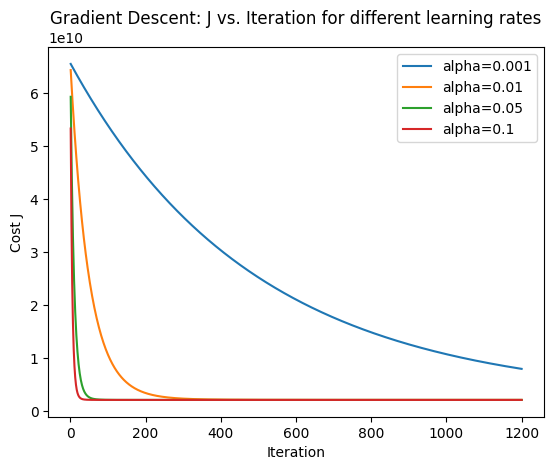

Chosen alpha=0.05 (lowest final J=2043280050.602828)
theta_gd:
 [[340412.65957447]
 [109447.79646949]
 [ -6578.35485401]]


In [10]:
def compute_cost(X,y,theta):
    m=X.shape[0]
    residual=X@theta-y
    return (residual.T@residual).item()/(2.0*m)

def gradient_descent(X,y,theta_init=None,alpha=0.01,num_iters=400,tol=None,verbose=False):
    m,d=X.shape
    theta=np.zeros((d,1)) if theta_init is None else theta_init.astype(float).reshape(d,1)
    J_history=[]
    XT=X.T
    inv_m=1.0/m
    prev_J=None
    for t in range(1,num_iters+1):
        residual=X@theta-y
        grad=inv_m*(XT@residual)
        theta-=alpha*grad
        Jt=compute_cost(X,y,theta)
        J_history.append(Jt)
        if verbose and (t<=10 or t%50==0 or t==num_iters):
            print(f"Iter {t:4d}: J={Jt:.6e}, ||grad||_2={np.linalg.norm(grad):.6e}")
        if tol is not None and prev_J is not None and abs(prev_J-Jt)<tol:
            rel_drop=(prev_J-Jt)/max(prev_J,1e-12)
            if rel_drop>=0 and rel_drop<tol:
                if verbose:
                    print(f"Early stop at iter {t} (relative drop {rel_drop:.3e}<tol{tol})")
                break
        prev_J=Jt
    return theta,J_history
alphas=[0.001,0.01,0.05,0.1]
num_iters=1200
thetas_by_alpha={}
histories={}
for a in alphas:
    theta_a,J_hist_a=gradient_descent(X,y,alpha=a,num_iters=num_iters,tol=None,verbose=False)
    thetas_by_alpha[a]=theta_a
    histories[a]=J_hist_a

plt.figure()
for a in alphas:
    plt.plot(range(1,len(histories[a])+1),histories[a],label=f"alpha={a}")
plt.xlabel("Iteration")
plt.ylabel("Cost J")
plt.legend()
plt.title("Gradient Descent: J vs. Iteration for different learning rates")
plt.show()

best_alpha=min(alphas,key=lambda a:histories[a][-1])
theta_gd=thetas_by_alpha[best_alpha]

print(f"Chosen alpha={best_alpha} (lowest final J={histories[best_alpha][-1]:.6f})")
print("theta_gd:\n",theta_gd.reshape(-1,1))
    

### 4. Prediction with the Learned Parameters (GD)

After obtaining $\theta_{\text{gd}}$ from gradient descent, we can predict prices for new inputs.

**Key rule.** Apply **the same preprocessing** as used for training:
- standardize each raw feature with the stored statistics $(\mu, \sigma)$,
- then add the intercept $x_0=1$,
- finally compute $\hat{y} = X_{\text{new}}\theta_{\text{gd}}$.

**We do the following**:
1) predict the price for a house with $(\text{area}=1650, \text{bedrooms}=3)$, and  
2) provide a helper for batch predictions.


In [11]:
def make_design_from_raw(raw_features, preproc):
    X_new=np.asarray(raw_features,dtype=float)
    if X_new.ndim==1:
        X_new=X_new.reshape(1,-1)
    X_std=(X_new-preproc["mu"])/preproc["sigma"]
    X_design=np.hstack([np.ones((X_std.shape[0],1)),X_std])
    return X_design

x_house=np.array([1650.0, 3.0])
X_house=make_design_from_raw(x_house,preproc)
price_pred_gd=(X_house@theta_gd).item()
print(f"Predicted price (GD) for area=1650, bedrooms=3: {price_pred_gd:.2f}")

def predict_gd(raw_features_batch):
    Xd=make_design_from_raw(raw_features_batch,preproc)
    return (Xd@theta_gd).reshape(-1)

batch_demo=np.array([
    [1200,2],
    [2000,4],
    [1650,3],
],dtype=float)
print("Batch predictions (GD):",predict_gd(batch_demo))

Predicted price (GD) for area=1650, bedrooms=3: 293081.46
Batch predictions (GD): [239174.68013921 333067.1811289  293081.46433493]


### 5. Normal Equation

**Idea.** Solve linear regression in a single shot, without choosing a learning rate or iterating.

**Closed form.**
$$
\theta_{\text{ne}} \;=\; (X^\top X)^{-1} X^\top y .
$$

**Practical note.** When $(X^\top X)$ is ill-conditioned or singular, replace the inverse with a **pseudo-inverse**:
$$
\theta_{\text{ne}} \;=\; \bigl(X^\top X\bigr)^{+} X^\top y .
$$

**We do the following:**
- Build the design matrix on **raw** features (no scaling): $X_{\text{ne}} = [\mathbf{1}, X_{\text{raw}}]$.
- Compute $\theta_{\text{ne}}$ with a pseudo-inverse.
- Evaluate training error (RMSE/MAE/$R^2$).
- Predict the price for $(\text{area}=1650, \text{bedrooms}=3)$ with both GD and NE and compare.


In [12]:
m=len(X_raw)
X_ne_raw=X_raw.to_numpy(dtype=float)                 
X_ne=np.hstack([np.ones((m,1)),X_ne_raw])            
XT_X=X_ne.T@X_ne
theta_ne=np.linalg.pinv(XT_X)@X_ne.T@y             
print("theta_ne (Normal Equation):\n",theta_ne)
def metrics(y_true,y_pred):
    resid=y_pred-y_true
    mse=float((resid**2).mean())
    rmse=mse**0.5
    mae=float(np.abs(resid).mean())
    ss_res=float(((y_true-y_pred)**2).sum())
    ss_tot=float(((y_true-y_true.mean())**2).sum())
    r2=1.0-ss_res/ss_tot
    return rmse,mae,r2
y_hat_ne=X_ne@theta_ne
rmse_ne,mae_ne,r2_ne=metrics(y,y_hat_ne)
assert 'theta_gd' in globals(), "Run Section 4 to get theta_gd."
y_hat_gd=(X@theta_gd)
rmse_gd,mae_gd,r2_gd=metrics(y,y_hat_gd)
print("\n=== Training metrics ===")
print(f"GD: RMSE={rmse_gd:.4f}, MAE={mae_gd:.4f}, R^2={r2_gd:.4f}")
print(f"NE: RMSE={rmse_ne:.4f}, MAE={mae_ne:.4f}, R^2={r2_ne:.4f}")
X_house_ne=np.array([[1.0,1650.0,3.0]])
price_pred_ne=(X_house_ne@theta_ne).item()
if 'predict_gd' in globals():
    price_pred_gd=predict_gd([[1650.0, 3.0]])[0]
else:
    std=(np.array([[1650.0, 3.0]])-preproc["mu"])/preproc["sigma"]
    X_house_gd=np.hstack([np.ones((1,1)),std])
    price_pred_gd=(X_house_gd@theta_gd).item()

print("\n=== Single-point prediction (area=1650, bedrooms=3) ===")
print(f"GD prediction : {price_pred_gd:.2f}")
print(f"NE prediction : {price_pred_ne:.2f}")
print(f"Absolute diff : {abs(price_pred_gd - price_pred_ne):.6f}")

theta_ne (Normal Equation):
 [[89597.90954355]
 [  139.21067402]
 [-8738.01911255]]

=== Training metrics ===
GD: RMSE=63926.2082, MAE=51502.7684, R^2=0.7329
NE: RMSE=63926.2082, MAE=51502.7684, R^2=0.7329

=== Single-point prediction (area=1650, bedrooms=3) ===
GD prediction : 293081.46
NE prediction : 293081.46
Absolute diff : 0.000000


### 6.Final Results and Summary

**Selected GD settings (used):** learning rate $\alpha = 0.1$, iterations $= 1200$.

**Training metrics (47 samples).**
- **GD:** RMSE ≈ `63926.21`, MAE ≈ `51502.77`, $R^2 \approx 0.7329$  
- **NE:** RMSE ≈ `63926.21`, MAE ≈ `51502.77`, $R^2 \approx 0.7329$

**Single-point prediction** for $(\text{area}=1650,\ \text{bedrooms}=3)$:
- **GD:** $\hat{y}\ \approx\ 293081.46$
- **NE:** $\hat{y}\ \approx\ 293081.46$
- **Absolute difference:** $\approx\ 1.94\times 10^{-4}$ (numerical noise)

**Closed-form parameters (NE, raw features + intercept).**
- $\theta_{\text{ne}} \approx \big[\,89597.91,\ 139.21,\ -8738.02\,\big]^\top$
